In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

In [5]:
data = MNIST(root ='data/' , download = True)

In [3]:
len(data)

60000

In [13]:
img , label = data[0]
print (label)

5


In [14]:
test_data=MNIST(root='data/' , train=False)
len(test_data)

10000

In [16]:
data[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1DE87ECA508>, 5)

Label: 2


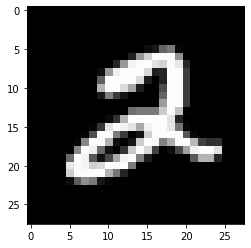

In [18]:
img,label=data[5]
plt.imshow(img,cmap='gray')
print('Label:',label)

Label: 3


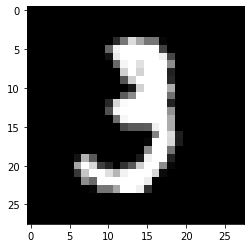

In [19]:
img,label=data[10]
plt.imshow(img,cmap='gray')
print('Label:',label)

In [25]:
data = MNIST(root = 'data/' , 
                   train = True,
                   transform = transforms.ToTensor())

In [29]:
image,label = data[0]
print(image.shape,label)

torch.Size([1, 28, 28]) 5


In [30]:
print(image[:,10:15,10:15])
print(torch.max(image),torch.min(image))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


In [32]:
class mnist_model(nn.Module):
    def __init__(self , input_size , hidden_size , output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size , hidden_size)
        self.linear2 = nn.Linear(hidden_size , output_size)
        
    def forward(self , xb):
        xb = xb.reshape(xb.size(0) , -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
model = mnist_model(784 , 32 , 10)

In [33]:
loss_function = F.cross_entropy

In [34]:
optimizer = torch.optim.Adam(model.parameters() , lr = 1e-1)

In [35]:
def split_index(dataset_size , split_percent):
    split_size = int(dataset_size * split_percent)
    random_idx = np.random.permutation(dataset_size)
    
    return random_idx[:split_size] , random_idx[split_size:]

In [36]:
val_idx , train_idx = split_index(len(mnist_data) , 0.10)  

print('Validation set length :' , len(val_idx))
print('Train set length :' , len(train_idx))

Validation set length : 6000
Train set length : 54000


In [37]:
def gpu_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    
    else:
        return torch.device('cpu')

In [38]:
device = gpu_device()
device

device(type='cpu')

In [39]:
def move_to_device(data , device):
    if isinstance(data , (list , tuple)):
        return [move_to_device(x , device) for x in data]
    return data.to(device , non_blocking = True)

In [40]:
train_sampler = SubsetRandomSampler(train_idx)
train_dl = DataLoader(mnist_data , batch_size = 512, sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_idx)
val_dl = DataLoader(mnist_data , batch_size = 512, sampler = val_sampler)

In [41]:
class gpu_dataloader():
    def __init__(self, dl , device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batches in self.dl:
            yield move_to_device(batches , self.device)
    
    def __len__(self):
        return len(self.dl)

In [42]:
train_dataloader = gpu_dataloader(train_dl , device)
val_dataloader = gpu_dataloader(val_dl , device)

In [43]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [44]:
def fit(model , train_dl , val_dl , loss_func , optim , num_epochs):
    
    acc = []
    losses = []
    for epochs in range(num_epochs):
        
        for xb , yb in train_dl:
            ## making prediction
            pred = model(xb)
            
            ## calculating loss function
            loss = loss_func(pred , yb)
    
            ##calculating gradients
            loss.backward()
    
            ##one step of optimization
            optim.step()
    
            ##reset the gradient
            optim.zero_grad()
            
        for val_x , val_y in val_dl:
            
            with torch.no_grad():
                
                ##calculating the prediction
                
                val_pred = model(val_x)
                
                val_loss = loss_func(val_pred , val_y)
                
                ##storing the validation loss
                losses.append(val_loss)
                
                ##getting accuracy
                res = accuracy(F.softmax(val_pred , dim = 1) , val_y)
                
                ##storing the accuracy
                acc.append(res)
                
        print('Epochs [ {} / {}] :- Loss : {:.4f} , Accuracy : {:.4f}'.format(epochs + 1 , num_epochs , val_loss , res))
        
    return acc , losses

In [45]:
model = move_to_device(model , device)

In [46]:
next(model.parameters()).is_cuda 

False

In [47]:

history = fit(model , train_dataloader , val_dataloader , loss_function , optimizer , 20)

Epochs [ 1 / 20] :- Loss : 0.6146 , Accuracy : 0.8152
Epochs [ 2 / 20] :- Loss : 0.4879 , Accuracy : 0.8913
Epochs [ 3 / 20] :- Loss : 0.2853 , Accuracy : 0.9022
Epochs [ 4 / 20] :- Loss : 0.2794 , Accuracy : 0.9212
Epochs [ 5 / 20] :- Loss : 0.5051 , Accuracy : 0.8832
Epochs [ 6 / 20] :- Loss : 0.3939 , Accuracy : 0.9076
Epochs [ 7 / 20] :- Loss : 0.3091 , Accuracy : 0.9212
Epochs [ 8 / 20] :- Loss : 0.3985 , Accuracy : 0.9076
Epochs [ 9 / 20] :- Loss : 0.3835 , Accuracy : 0.9049
Epochs [ 10 / 20] :- Loss : 0.4132 , Accuracy : 0.9076
Epochs [ 11 / 20] :- Loss : 0.2917 , Accuracy : 0.9321
Epochs [ 12 / 20] :- Loss : 0.3996 , Accuracy : 0.9239
Epochs [ 13 / 20] :- Loss : 0.2451 , Accuracy : 0.9484
Epochs [ 14 / 20] :- Loss : 0.3315 , Accuracy : 0.9130
Epochs [ 15 / 20] :- Loss : 0.3404 , Accuracy : 0.9239
Epochs [ 16 / 20] :- Loss : 0.4239 , Accuracy : 0.8913
Epochs [ 17 / 20] :- Loss : 0.3076 , Accuracy : 0.9076
Epochs [ 18 / 20] :- Loss : 0.3880 , Accuracy : 0.9266
Epochs [ 19 / 20] :